In [1]:
!rm -rf ./tmp

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mmcv
from mmengine.visualization import Visualizer
from pprint import pprint
import pandas as pd
from mmpose.apis import MMPoseInferencer

# ## DEFINE MODELS

# ### Faster RCNN for Human Detection
# mmdet_config_path = './modules/human_detector/config/faster_rcnn.py'
# mmdet_model_weight = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/'\
#         'faster_rcnn_r50_fpn_1x_coco-person/faster_rcnn_r50_fpn_1x_coco-person_20201216_175929-d022e227.pth'

# ### HR-Net for 2D Pose Estimation
# mmpose_config_path = './modules/pose_estimator_2d/config/hrnet.py'
# mmpose_model_weight = 'https://download.openmmlab.com/mmpose/v1/'\
#         'body_2d_keypoint/topdown_heatmap/coco/'\
#             'td-hm_hrnet-w48_udp-8xb32-210e_coco-384x288-70d7ab01_20220913.pth'
# mmpose_inferencer = MMPoseInferencer(
#     pose2d=mmpose_config_path,
#     pose2d_weights=mmpose_model_weight,
#     det_model=mmdet_config_path,
#     det_weights=mmdet_model_weight,
#     det_cat_ids=[0]
# )

In [18]:
import json
with open('/root/data/processed/drive_and_act/annotations/person_keypoints_val.json') as f:
    ann_obj = json.loads(f.read())
with open('/root/data/processed/drive_and_act/keypoint_detection_results/keypoint_detection_val.json') as f:
    kp_list = json.loads(f.read())
with open('/root/data/processed/drive_and_act/person_detection_results/human_detection_val.json') as f:
    detect_list = json.loads(f.read())
img_info = {}
kp_info = {}
detect_info = {}
print(kp_list[0])
for img in ann_obj['images']:
    img_info[img['id']] = img
for img in kp_list:
    kp_info[img['image_id']] = img
for img in detect_list:
    detect_info[img['image_id']] = img

{'image_id': 7505, 'category_id': 1, 'keypoints': [716.6387, 336.7927, 0.879, 712.4927, 310.5098, 0.6889, 691.4852, 338.867, 0.8819, 575.6882, 144.8135, 0.3058, 564.6875, 373.504, 0.9079, 456.6458, 232.3677, 0.6766, 541.2865, 461.3935, 0.4205, 436.7356, 212.6197, 0.2835, 811.9435, 349.7702, 0.4455, 768.2253, 367.9785, 0.1381, 884.4549, 379.4315, 0.6467, 389.3656, 404.9013, 0.4774, 631.092, 479.6581, 0.4949, 691.9365, 300.0732, 0.1493, 820.7083, 352.9618, 0.747, 743.1701, 338.8861, 0.0877, 923.6041, 409.4025, 0.0828], 'score': 0.450942724943161, 'scale': [758.75, 1011.6667], 'center': [594.5, 329.5]}


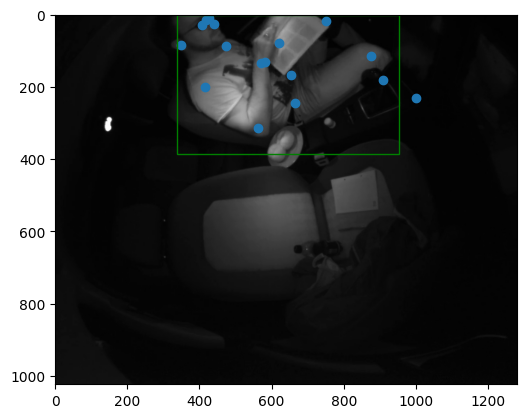

In [55]:
# for annotation in ann_obj['annotations']:
annotation = ann_obj['annotations'][800]
file_name = img_info[annotation['id']]['file_name']
file_path = f'/root/data/processed/drive_and_act/images/val/{file_name}'
# print(annotation.keys())
kp2D = np.array(kp_info[annotation['id']]['keypoints']).reshape(-1, 3)
fig, ax = plt.subplots()
# print(file_name)
ax.imshow(plt.imread(file_path))
ax.scatter(kp2D[:, 0], kp2D[:, 1])
# print(kp2D)
bbox = detect_info[annotation['id']]['bbox']
x = bbox[0]
y = bbox[1]
# w = bbox[2]
# h = bbox[3]
w = bbox[2] - bbox[0]
h = bbox[3] - bbox[1]
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none', label='high bbox')
ax.add_patch(rect)

Output()

Output()

Output()

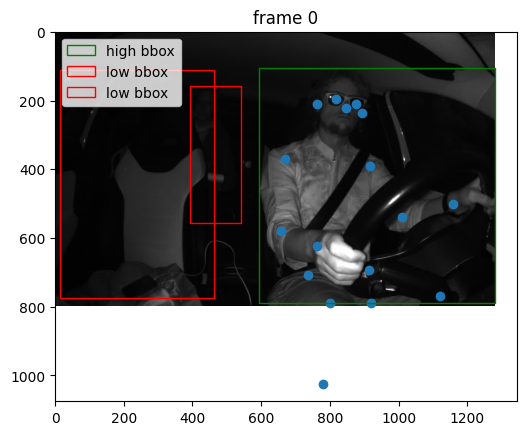

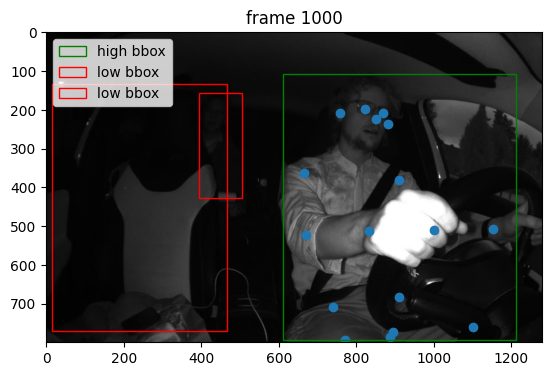

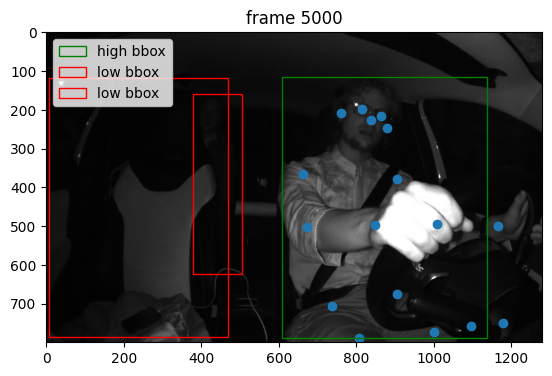

In [3]:
images = []
cv2.imread()
## Model Inference
mmpose_results = mmpose_inferencer(images)
for idx, mmpose_result in enumerate(mmpose_results):
    image_results = mmpose_result['predictions'][0]
    fig, ax = plt.subplots()
    ax.imshow(images[idx])
    ax.set_title(f'frame {frame_numbers[idx]}')
    # find the best box
    best_box_idx = np.argmax([box['bbox_score'] for box in image_results])
    for idx, detected in enumerate(image_results):
        ## bounding box in top-left / bottom-right format
        bbox = detected['bbox']
        x = bbox[0][0]
        y = bbox[0][1]
        w = bbox[0][2] - bbox[0][0]
        h = bbox[0][3] - bbox[0][1]
        if idx != best_box_idx:
            # draw lower match bbox as red
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none', label='low bbox')
        else:
            # draw highest match bbox as green
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none', label='high bbox')
            # plot 2D keypoints
            pose_2d = np.array(detected['keypoints'])
            ax.scatter(pose_2d[:, 0], pose_2d[:, 1])
        ax.add_patch(rect)
    ax.legend(loc='upper left')